# COMP2200/COMP6200 Prac 1

_Authors: Greg Baker (greg.baker@mq.edu.au)_

---

The City of Baltimore publishes data about all of its employees, including their salaries. And these annual salaries can differ from their gross pay: Perhaps an employee works nightshift/overtime and earns more than their official salary; perhaps they are only employed for a part of the year and earn less.

In this lab, we'll estimate what a typical city employee's gross pay will be based on their annual salary.

Remember that to use a notebook, you need to run each cell. If left side of a cell says `[ ]`, it hasn't been run. If the left side
says something like `[25]` then it has been. Shift-Enter runs a cell;  if you look around the user interface, various other menu items can run several cells in sequence.

**Note**

This prac will cover a very complete data science lifecycle. Unfortunately, this requires some skills that we don't know yet. So there are some blocks of code that do things which we haven't explained yet. That's OK. We'll get there.

Here are the steps we'll do:

- Data Acquisition -- there will be a little of coding for you here

- Data Cleaning and Preparation

- Training -- there will be a little bit here for you to do as well

- Validation -- lots to do here

- Evaluation -- lots to do here

# Data Acquisition

Don't worry too much about the following blocks of code. Over the next few weeks you'll get more comfortable with this, and you'll
see that a lot of data science programming work is simple and easy-to-repeat.

First up, let's load the libraries we need:

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import sklearn.linear_model
import sklearn.model_selection
import sklearn.metrics

The Baltimore salaries data set is available in `Baltimore_City_Employee_Salaries_2011.csv`. This is a file and needs to be in the same directory as this notebook. Column 0 is the name of the employee and we'll use it as an index. Column 4 is a date. (Note that we count columns starting with "0").

The pandas `read_csv` function reads it into a dataframe called `salaries`

In [2]:
salaries = pd.read_csv('Baltimore_City_Employee_Salaries_2011.csv', 
                       index_col=0,
                      parse_dates=[4])
salaries.head()

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay
Name,,,,,,
"Aaron,Patricia G",Facilities/Office Services II,A03031,OED-Employment Dev,1979-10-24,$50845.00,$45505.94
"Aaron,Petra L",ASSISTANT STATE'S ATTORNEY,A29005,States Attorneys Office,2006-09-25,$56595.00,$51588.89
"Abaineh,Yohannes T",EPIDEMIOLOGIST,A65026,HLTH-Health Department,2009-07-23,$56500.00,$50633.26
"Abdal-Rahim,Naim A",EMT Firefighter,A64063,Fire Academy Recruits,2011-03-30,$33476.00,$3888.95
"Abdi,Ezekiel W",POLICE OFFICER,A99398,Police Department,2007-06-14,$50919.00,$51421.73


## Your Turn....

Last week you learned about the `.tail()` method to see the last few rows in a database. Use that now to look at
the end of the `salaries` dataframe.

In [3]:
salaries.tail10 = salaries.tail(10)

C:\Users\Admin\AppData\Local\Temp\ipykernel_19124\3259108167.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  salaries.tail10 = salaries.tail(10)


You can also use `.sample(5)` to get 5 random rows from the `salaries` dataframe.

In [4]:
print(salaries.tail10)

                                       JobTitle AgencyID  \
Name                                                       
Lewis,Andrea N              CALL CENTER AGENT I   A40002   
Lewis,Angelo S      MECHANICAL SWEEPER OPERATOR   B70403   
Lewis,Anthony      RECREATION CENTER DIRECTOR I   A04001   
Lewis,Anthony L            MAINTENANCE MECHANIC   A91014   
Lewis,Antione J                  POLICE OFFICER   A99195   
Lewis,Awanda S   SCHOOL HEALTH AIDE (10 MONTHS)   A65104   
Lewis,Bernard T              FIRE PUMP OPERATOR   A64120   
Lewis,Brian C                    POLICE OFFICER   A99322   
Lewis,Capri T                 JTPA TRAINEE MOMR   W03T19   
Lewis,Carlos E                     CARPENTER II   A50212   

                                  Agency   HireDate AnnualSalary   GrossPay  
Name                                                                         
Lewis,Andrea N       M-R Info Technology 2005-07-05    $33841.00  $26939.01  
Lewis,Angelo S           DPW-Solid Waste 2004

# Data Preprocessing

## Preprocess the Data (Convert Strings to Numbers)

The `AnnualSalary` and `GrossPay` columns are strings and start with a `$`. We'll have to strip this off and convert these columns to floats.

Don't worry too much about this code... just confirm that it works by checking that it now looks like a number without a `$` sign.

In [5]:
salaries.AnnualSalary = salaries.AnnualSalary.str.strip('$').astype(float)
salaries.GrossPay = salaries.GrossPay.str.strip('$').astype(float)
salaries.head()

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay
Name,,,,,,
"Aaron,Patricia G",Facilities/Office Services II,A03031,OED-Employment Dev,1979-10-24,50845.0,45505.94
"Aaron,Petra L",ASSISTANT STATE'S ATTORNEY,A29005,States Attorneys Office,2006-09-25,56595.0,51588.89
"Abaineh,Yohannes T",EPIDEMIOLOGIST,A65026,HLTH-Health Department,2009-07-23,56500.0,50633.26
"Abdal-Rahim,Naim A",EMT Firefighter,A64063,Fire Academy Recruits,2011-03-30,33476.0,3888.95
"Abdi,Ezekiel W",POLICE OFFICER,A99398,Police Department,2007-06-14,50919.0,51421.73


## Perform Exploratory Data Analysis

Create a scatterplot of annual salary versus gross pay.

<Axes: xlabel='AnnualSalary', ylabel='GrossPay'>

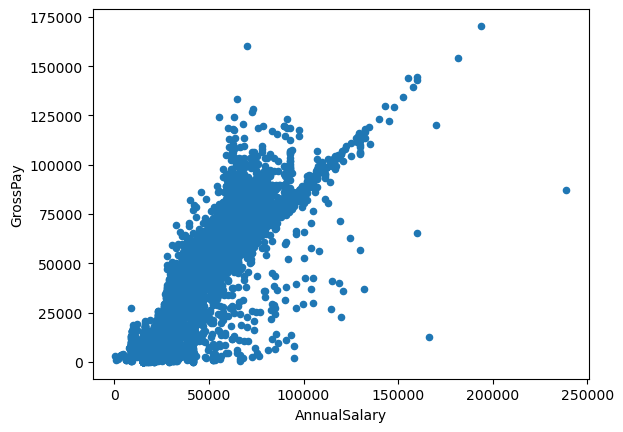

In [6]:
salaries.plot.scatter(x='AnnualSalary', y='GrossPay')

# Look for a Linear Relationship

It seems like there is a linear relationship in there, but it's obscured by a lot of noise.

Let's get a vibe for the data, and what we should expect to see in our machine generated model.

We will extract a tiny sample of it and do an approximation of the Theil-Sen algorithm by hand.

Note that because we are _sampling_ the data, everyone is going to get a different subset of the data here.

In [7]:
tiny_sample = salaries.sample(10)
tiny_sample

,JobTitle,AgencyID,Agency,HireDate,AnnualSalary,GrossPay
Name,,,,,,
"Johnson,Denel E",LABORER,B70105,DPW-Solid Waste,2005-10-03,28059.0,24951.06
"Jackson,Thomas P",POLICE OFFICER,A99321,Police Department,1994-12-19,63384.0,58000.70
"Christian,Philbert E",ENVIRONMENTAL SANITARIAN II,A65041,HLTH-Health Department,1988-07-11,57320.0,51808.69
"Keene,Garrett S",POLICE OFFICER (EID),A99333,Police Department,2002-01-22,63745.0,56326.75
"Nunez,Luis A",POLICE OFFICER,A99094,Police Department,2006-06-14,54125.0,40384.80
"Ckyyou,Dianna L",POLICE OFFICER,A99031,Police Department,1991-03-18,65669.0,61622.44
"Doll,Edward W",PARAMEDIC EMT-P,A64462,Fire Department,1998-05-04,65292.0,80934.58
"Watkins,Charlene",POLICE OFFICER,A99310,Police Department,1985-11-22,68523.0,84963.66
"Bailey,Rose",Human Services,A03031,OED-Employment Dev,1986-09-08,45243.0,40786.59


The next cell creates an image

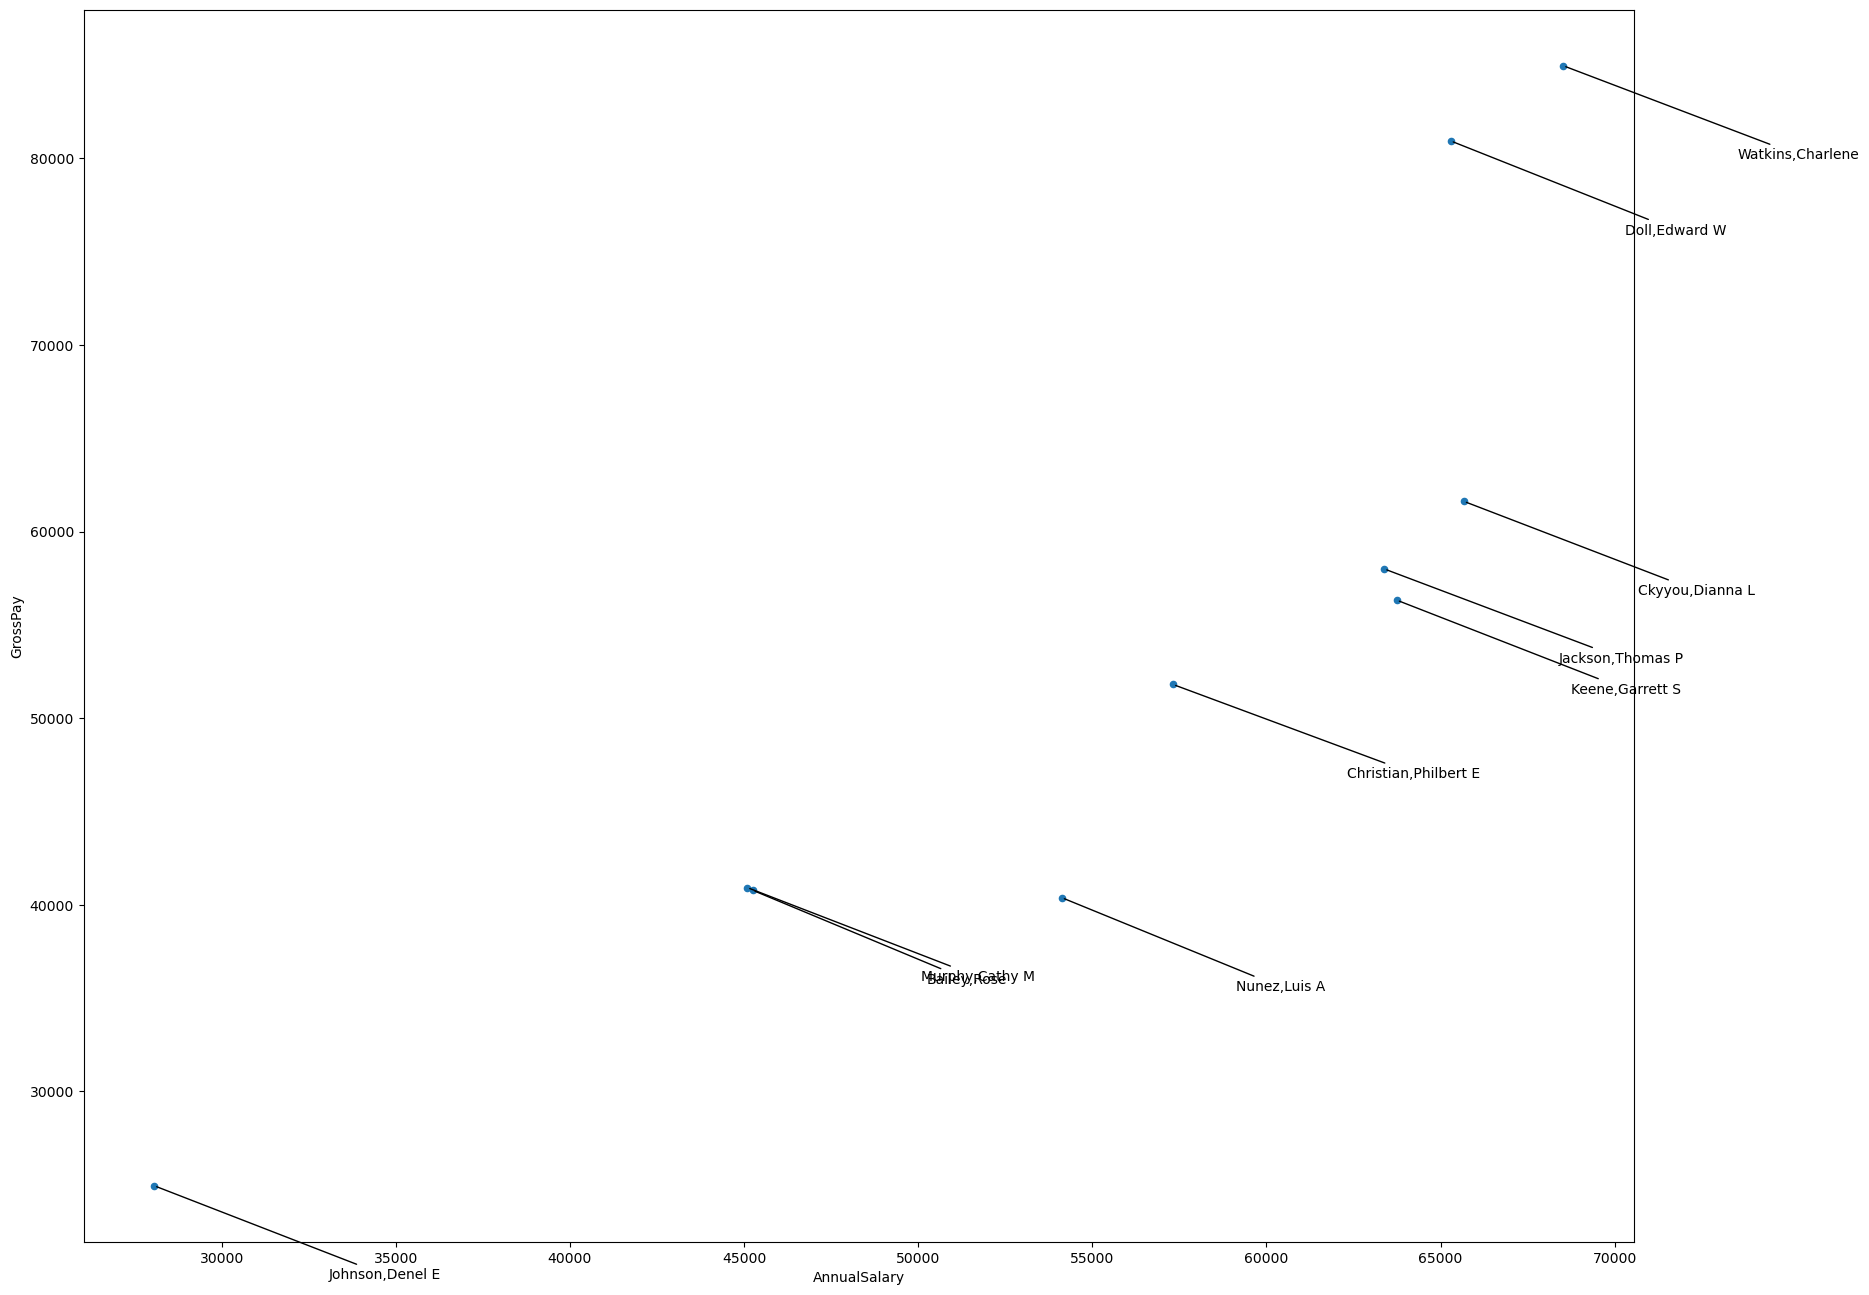

In [8]:
fig, ax = plt.subplots(figsize=(20,16))
tiny_sample.plot.scatter(x='AnnualSalary', y='GrossPay', ax=ax)
for name, details in tiny_sample.iterrows():
    ax.annotate(text=name, xy=(details.AnnualSalary,details.GrossPay), xytext=(details.AnnualSalary+5000, details.GrossPay-5000),
                arrowprops=dict(arrowstyle="-", color='black')
               )

Take that image, and open it in an editing tool that has a ruler tool.

**Windows** You could use *Microsoft Paint* (type "Paint" in the start menu) or *Snipping Tool / Snip & Sketch* (Take a screenshot with Windows + Shift + S and then annotate directly on the captured image.)

**macOS** Preview or Quick Look

The next cell will give you a five random pairs of people to draw a line between. Draw them, and then **save the image into your
github classroom repo so that we know that you've done it**.

In [9]:
for i in range(5):
    pair = tiny_sample.sample(2)
    first_name = pair.index[0]
    second_name = pair.index[1]
    print(f"""
Draw a line that goes through {first_name} and {second_name}. 

This should go through ({pair.AnnualSalary.iloc[0]},{pair.GrossPay.iloc[0]}) and ({pair.AnnualSalary.iloc[1]},{pair.GrossPay.iloc[1]})

It has a gradient (slope) of {(pair.GrossPay.iloc[1]-pair.GrossPay.iloc[0])/(pair.AnnualSalary.iloc[1]-pair.AnnualSalary.iloc[0])}

-----------------------------
""")


Draw a line that goes through Christian,Philbert E and Jackson,Thomas P. 

This should go through (57320.0,51808.69) and (63384.0,58000.7)

It has a gradient (slope) of 1.0211098284960414

-----------------------------


Draw a line that goes through Keene,Garrett S and Doll,Edward W. 

This should go through (63745.0,56326.75) and (65292.0,80934.58)

It has a gradient (slope) of 15.906806722689076

-----------------------------


Draw a line that goes through Watkins,Charlene and Christian,Philbert E. 

This should go through (68523.0,84963.66) and (57320.0,51808.69)

It has a gradient (slope) of 2.9594724627331965

-----------------------------


Draw a line that goes through Keene,Garrett S and Doll,Edward W. 

This should go through (63745.0,56326.75) and (65292.0,80934.58)

It has a gradient (slope) of 15.906806722689076

-----------------------------


Draw a line that goes through Watkins,Charlene and Bailey,Rose. 

This should go through (68523.0,84963.66) and (45243.0,40786.5

### Get an estimate

Which was the "middle" slope line on your diagram? i.e. what was the median gradient? 

(Write it in the next cell so that we know you did it. Note that it's unlikely that two students will get the same answer.)

Answer:   Mansby Kately M to Doll Edwads W, median gradiant is 1.897640

### A moment of reflection

Does that mean that Baltimore employees typically get more pay than their salary, or less than their salary?

(Write it in the next cell so that we know you did it. You might or might not have the same answer as your neighbour, but generally you will.)

_Answer: It's hard to tell if Baltimore employees typically get more pay than their salary, or less than their salary only considering the middle slope. Because, there are some ppl(especially emergency workers) who get overtime where as, some ppl's salary get unpaid leave, work part time etc. 

# Data Splitting

We need to have train, validation and test data. (We actually should have done that before we did our manual Theil-Sen algorithm.)

In [10]:
training_data, holdout_data = sklearn.model_selection.train_test_split(salaries, test_size=0.2)
validation_data, test_data = sklearn.model_selection.train_test_split(holdout_data, test_size=0.5)

In [11]:
training_data.shape, validation_data.shape, test_data.shape

((11563, 6), (1445, 6), (1446, 6))

# Scikit Learn Regression

We'll follow the pattern we followed in the code from lectures:

- Construct a Regressor object

- `.fit()` it

- Use it to `.predict()` the validation data

- Look at the coefficients of the model (in this case, the gradient).

### Theil-Sen

You just did a Theil-Sen regression by hand, and we saw one in class. Let's see how close your five-sample version was to a more complete computation.

In [12]:
ts = sklearn.linear_model.TheilSenRegressor()
ts.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
ts_predictions = ts.predict(validation_data[['AnnualSalary']])
ts.coef_

array([0.97405472])

### RANSAC

Let's use a RANSAC regressor. This was demonstrated in class. (Getting the coefficients for a RANSAC model is a little unusual: you ask for the best estimator, and then you ask for the coefficients of that best estimator.

In [13]:
ransac = sklearn.linear_model.RANSACRegressor()
ransac.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
ransac_predictions = ransac.predict(validation_data[['AnnualSalary']])
ransac.estimator_.coef_

array([0.97668346])

### Huber

One of the best and most robust regressors is the Huber model. Finish off this code.

In [16]:
huber = sklearn.linear_model.HuberRegressor()
huber.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
huber_predictions = huber.predict(validation_data[['AnnualSalary']])
huber.coef_


array([0.91153143])

### Ordinary Least Squares

If you have done STAT1170 you might have encountered this choice for finding a line of best fit through some points.

It is very common and popular, so the scikit learn class is called `LinearRegression()`

Finish off this code:

In [22]:
ols = sklearn.linear_model.LinearRegression()
ols.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
ols_predictions = ols.predict(validation_data[['AnnualSalary']])
ols.coef_

array([1.01520722])

# Evaluating these models

How wrong were the predictions? We can subtract the prediction from the correct answer to look.

In [17]:
validation_data.GrossPay - ts_predictions

Name
Brown,Raschad M             314.769606
Mason Jr,Frank J          25239.004846
Uttenreither,Charles L    -2229.823129
McAllister,Robert L        -234.226498
Prioleau,Sherrie K         5351.913859
                              ...     
Fyffe Jr,Danny L          11777.424209
Foye,Shakisha L            2120.600204
Campbell Jr,Donald W       6046.948925
Moore,Stella M            -4648.406812
Healey,William P          -2584.312974
Name: GrossPay, Length: 1445, dtype: float64

In [18]:
validation_data.GrossPay - ransac_predictions

Name
Brown,Raschad M            -796.827431
Mason Jr,Frank J          24075.195747
Uttenreither,Charles L    -3408.140251
McAllister,Robert L       -1349.672012
Prioleau,Sherrie K         4246.478592
                              ...     
Fyffe Jr,Danny L          10581.010831
Foye,Shakisha L             936.197546
Campbell Jr,Donald W       4931.571758
Moore,Stella M            -5717.841466
Healey,William P          -3794.235454
Name: GrossPay, Length: 1445, dtype: float64

Now look at the data for your Huber regressor and your Ordinary Least Squares regressor. (Put the calculations into the next two cells.)

In [23]:
huber = sklearn.linear_model.HuberRegressor()
huber.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
huber_predictions = huber.predict(validation_data[['AnnualSalary']])
huber.coef_

array([0.91153143])

In [24]:
ols = sklearn.linear_model.LinearRegression()
ols.fit(training_data[['AnnualSalary']], training_data['GrossPay'])
ols_predictions = ols.predict(validation_data[['AnnualSalary']])
ols.coef_

array([1.01520722])

## Summarising how wrong they were

Ideally, we'd like a number that says which one was the best. But choosing which way we calculate that number is a decision
that reflects what we think is important. These are questions we might ask:

- What's the most inaccurate prediction?

- 99% of the time, the correct answer was within ____ of what we predicted?

- On average, how far away from the right answer were we?


Here's how to get the most inaccurate prediction for the Theil-Sen regressor. (The maximum of the absolute values of the error in our prediction.). In the following cells, do RANSAC, Huber and Ordinary Least Squares

In [19]:
(validation_data.GrossPay - ts_predictions).abs().max()

74026.0213847985

In [25]:
(validation_data.GrossPay - huber_predictions).abs().max()

71724.68279573145

In [26]:
(validation_data.GrossPay - ransac_predictions).abs().max()

75301.59142343163

In [27]:
(validation_data.GrossPay - ols_predictions).abs().max()

77083.05032821877

(If you are ahead of the rest of the prac group and are waiting around idle, you could use `idxmax()` instead of `max()` to find out _which_ employee was most badly mis-predicted.)

------

99% of the predictions were wrong by less than this amount.... (fill in RANSAC, Huber and Ordinary Least Squares)

In [28]:
(validation_data.GrossPay - ts_predictions).abs().quantile(0.99)

np.float64(36866.58189083346)

In [29]:
(validation_data.GrossPay - ransac_predictions).abs().quantile(0.99)

np.float64(36604.04775670168)

In [30]:
(validation_data.GrossPay - huber_predictions).abs().quantile(0.99)

np.float64(38383.415110564114)

In [31]:
(validation_data.GrossPay - ols_predictions).abs().quantile(0.99)

np.float64(36280.854589867304)

Here's how we could get the mean absolute error (how far we are away from the right answer on average). sklearn has many built-in functions for doing these sorts of calculations. (Fill in RANSAC, Huber and Ordinary Least Squares).

In [32]:
sklearn.metrics.mean_absolute_error(validation_data.GrossPay, ts_predictions)

6171.155740549136

In [33]:
sklearn.metrics.mean_absolute_error(validation_data.GrossPay, ransac_predictions)

6088.812377028631

In [34]:
sklearn.metrics.mean_absolute_error(validation_data.GrossPay, huber_predictions)

6095.9994279468865

In [35]:
sklearn.metrics.mean_absolute_error(validation_data.GrossPay, ols_predictions)

6157.6304014426805

A very common measure (which you might have encountered in STAT1170 if you've done it) is the $R^2$ measure:

In [36]:
sklearn.metrics.r2_score(validation_data.GrossPay, ts_predictions)

0.809578788575349

In [37]:
sklearn.metrics.r2_score(validation_data.GrossPay, ransac_predictions)

0.8100511954845349

In [38]:
sklearn.metrics.r2_score(validation_data.GrossPay, huber_predictions)

0.8029848156564799

In [39]:
sklearn.metrics.r2_score(validation_data.GrossPay, ols_predictions)

0.8114747386357417

## Time to choose!

On the basis of the information you chose above, which regressor are you going to choose to use?

Say which model you think is best, and the basis you chose for using it. (While there are some obviously wrong answers you can give here, there are many options for the "right" answer depending on your criteria for best.)

Answer_: Since Linear Regression has the highest $R^2$  value (0.8115), it is the best choice among these models. A higher indicates that the model explains more variance in the dependent variable, making it the most effective at prediction.

  

  

### Evaluating it

You don't want to run `.fit()` again, but you do want to run `.predict()` again, using the model that you chose in the last section,
but this time using the test data. Call the variable that stores those predictions `test_predictions`.

In [51]:
test_predictions = ols.predict(test_data[['AnnualSalary']])

Using the measure that you thought was the most important --- the reason you chose that model over the others --- evaluate how good your chosen model is.

i.e. if you thought $R^2$ score was the most important, you would copy that same metric calculation here, comparing `test_data.GrossPay` to `test_predictions`.

In [52]:
sklearn.metrics.mean_absolute_error(test_data.GrossPay, test_predictions)

5973.998119146943

# A completely different analysis

Now imagine that you are the City of Baltimore's hiring manager. New employees regularly ask how much they are actually likely to earn given the salary to which they are about to agree.

You don't want to give an answer that is too high because you might be putting the city at risk for a lawsuit for misrepresenting the job. On the other hand, you don't want to give an answer that's too low because the candidate might pass up on the job and work elsewhere.

You decide that it will cost \\$0.05 in lawsuit risk for each dollar you overrepresent, but only \\$0.01 for each dollar you underrepresent.

E.g., if a candidate is actually likely to earn \\$100,000 and you say \\$120,000, this is worth \\$10,000 in potential lawsuits for misrepresentation. If you say \\$80,000, then that will cost you \$200 in potential recruiters' fees to find someone else.

Here's a function that will calculate the cost of these predictions. Don't worry if it is too complicated for you to create
by yourself right now, but see if you can make sense of how it works

In [53]:
def cost(actuals, predictions):
    cost = 0.0
    for actual,prediction in zip(actuals, predictions):
        if prediction > actual:
            cost += 0.05 * (prediction - actual)
        elif prediction < actual:
            cost += 0.01 * (actual - prediction)
        else:
            cost += 0.0
    return cost

Here's how you would use it for the Theil-Sen predictions. Use it to calculate the cost of the RANSAC, Huber and Ordinary Least Squares Regressors.

In [54]:
cost(validation_data['GrossPay'], ts_predictions)

np.float64(248886.19158624343)

In [55]:
cost(validation_data['GrossPay'], ransac_predictions)

np.float64(278561.86895023286)

In [56]:
cost(validation_data['GrossPay'], huber_predictions)

np.float64(265188.712153915)

In [57]:
cost(validation_data['GrossPay'], ols_predictions)

np.float64(279997.67727877334)

Based on this, which of the models we created today model would be the best one to use for answering new employees' questions?

_Answer: Theil-Sen

# Very much optional, super-hard question

If you are already familiar with Python programming, calculus or other data science concepts, try to find the optimal coefficients of a linear regression model which would minimise the hiring manager's regret.